# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [490]:
import copy
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [8]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [9]:
def generate_synthetic(size: int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [391]:
def mse(y_true: np.ndarray, y_pred: np.ndarray):    
    return np.sum((y_true - y_pred)**2) / y_true.shape[0]

def r2(y_true: np.ndarray, y_pred: np.ndarray):
    y_mean = np.mean(y_true)
    denominator = np.sum((y_true - y_mean)**2)
    numerator = np.sum((y_true - y_pred)**2)
    
    return 1 - numerator / denominator

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [12]:
class NormalLR:
    def __init__(self, normalize=False, alpha=0.0):
        self.normalize = normalize
        self.alpha = alpha
        
        self._w = None
        
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:        
        return np.hstack([X, np.ones((X.shape[0], 1))])
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'NormalLR':
        if self.normalize:
            self._mean, self._std = X.mean(axis=0), X.std(axis=0)
            X = (X - self._mean) / self._std
        X = self._add_intercept(X)

        X_inverse = np.linalg.inv(X.T @ X + self.alpha * np.identity(X.shape[1]))
        self._w = X_inverse @ X.T @ y
        
        return self
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.normalize:
            X = (X - self._mean) / self._std
        X = self._add_intercept(X)
              
        return (X @ self._w.reshape(-1, 1)).ravel()

In [13]:
er_mse, er_r2 = [], []
for _ in range(100):
    X, y = generate_synthetic(1024)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    
    y_pred = NormalLR().fit(X_train, y_train).predict(X_test)
    er_mse.append(mse(y_test, y_pred))
    er_r2.append(r2(y_test, y_pred))
    
print(f"MSE: {np.mean(er_mse)} ± {np.std(er_mse)},\nR2: {np.mean(er_r2)} ± {np.std(er_r2)}")

MSE: 0.009999576496946928 ± 0.0010548658720274475,
R2: 0.9979238450664422 ± 0.0015494613019728467


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [343]:
class GradientLasso:
    def __init__(self, alpha: float, normalize=False, tol=1e-8, iterations=10000, l=0.0):
        self.alpha = alpha
        self.normalize = normalize
        
        self.l = l
        self.tol = tol
        self.max_iter = iterations
        
    def _grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return (1 / y.shape[0]) * X.T @ (X @ w - y) + self.l * np.sign(w)
        
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:        
        return np.hstack([X, np.ones((X.shape[0], 1))])    
    
    def _prep_data(self, X, fit=True):
        if self.normalize:
            if fit:
                self._mean, self._std = X.mean(axis=0), X.std(axis=0)
            X = (X - self._mean) / self._std
            
        return self._add_intercept(X)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'GradientLasso':
        X, y = self._prep_data(X), y.reshape(-1, 1)
        
#         self._w = np.random.uniform(size=(X.shape[1], 1))
        self._w = np.zeros((X.shape[1], 1))
        
        for _ in range(self.max_iter):
            grad = self._grad(X, y, self._w)
            self._w = self._w - self.alpha * grad 

            if grad.T @ grad <= self.tol:
                break
        
        return self
        
    def predict(self, X: np.ndarray):
        X = self._prep_data(X, fit=False)
        
        return (X @ self._w).ravel()

In [393]:
def build_plot(X_train, y_train, X_test, y_test, l_range=None):
    if l_range is None:
        l_range = (0.0, 0.002, 0.00002)

    xs = np.arange(*l_range)
    errors = []
    for x in xs:
        regr = GradientLasso(alpha=0.1, normalize=True, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.xlabel("$\lambda$")
    plt.ylabel("MSE")
    plt.show()

In [395]:
er_mse, er_r2 = [], []
for _ in range(100):
    X, y = generate_synthetic(1024)
    X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
    
    y_pred = GradientLasso(0.1, iterations=10000).fit(X_train, y_train).predict(X_test)
    er_mse.append(mse(y_test, y_pred))
    er_r2.append(r2(y_test, y_pred))
    
print(f"MSE: {np.mean(er_mse)} ± {np.std(er_mse)},\nR2: {np.mean(er_r2)} ± {np.std(er_r2)}")

MSE: 0.009940052956744865 ± 0.001130028947094236,
R2: 0.9979221629508692 ± 0.001784591558888858


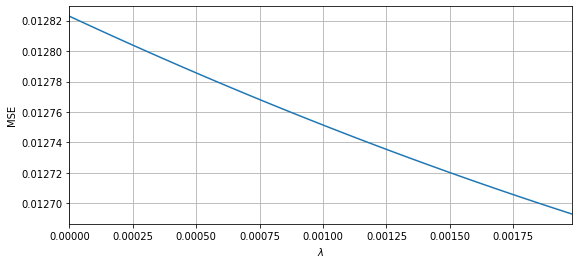

In [396]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

build_plot(X_train, y_train, X_val, y_val)

### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [577]:
X, y = read_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [402]:
model_ols = NormalLR(normalize=True)
model_ols.fit(X_train, y_train)
y_pred = model_ols.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 22266311.080836907, R2: 0.687279747566105


In [403]:
model_lasso = GradientLasso(0.1, normalize=True, iterations=10000, l=100)
model_lasso.fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 21684584.079713065, R2: 0.6954498397730546


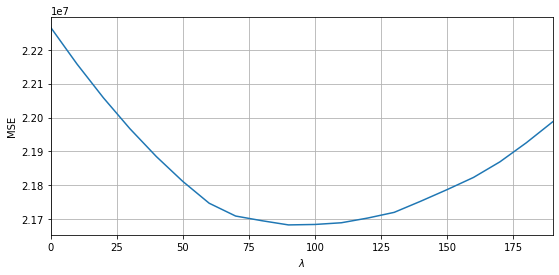

In [410]:
build_plot(X_train, y_train, X_test, y_test, (0.0, 200, 10.0))

### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [413]:
!head -n 14 boston.csv

#  1. crim     per capita crime rate by town
#  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
#  3. indus    proportion of non-retail business acres per town
#  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  5. nox      nitric oxides concentration (parts per 10 million)
#  6. rm       average number of rooms per dwelling
#  7. age      proportion of owner-occupied units built prior to 1940
#  8. dis      weighted distances to five Boston employment centres
#  9. rad      index of accessibility to radial highways
# 10. tax      full-value property-tax rate per $10,000
# 11. ptratio  pupil-teacher ratio by town
# 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
# 13. lstat    % lower status of the population
# 14. medv     median value of owner-occupied homes in $'s


In [625]:
def feature_weights(model):
    features = ["crim", "zn", "indus", "chas", 
                "nox", "rm", "age", "dis", "rad",
                "tax", "ptratio", "b", "lstat"]

    table = sorted(zip(features, model._w), key=lambda t: abs(t[1]))
    print(tabulate([("Feature", "Weight")] + table, headers="firstrow", tablefmt="github"))
    
    
def feature_importance(X, y, model):
    ref_score = r2(y, model.predict(X))
    feature_scores = []
    features = ["crim", "zn", "indus", "chas", 
                "nox", "rm", "age", "dis", "rad",
                "tax", "ptratio", "b", "lstat"]
    
    for feature in range(X.shape[1]):
        scores = np.zeros(100)
        for i in range(100):
            X_new = X.copy()
            np.random.shuffle(X_new[:, feature], )
            scores[i] = r2(y, model.predict(X_new))
            
        feature_scores.append([features[feature], ref_score - np.mean(scores), np.std(scores)])
    
    table = [["Feature", "Importance", "Std"]] + sorted(feature_scores, key=lambda t: t[1])
        
    print(tabulate(table, headers="firstrow", tablefmt="github"))

In [626]:
feature_importance(X_test, y_test, model_lasso)

| Feature   |   Importance |         Std |
|-----------|--------------|-------------|
| indus     | -0.00297712  | 0.00315056  |
| age       |  4.77472e-07 | 3.14833e-05 |
| crim      |  0.00504248  | 0.00660897  |
| zn        |  0.00704661  | 0.00884733  |
| b         |  0.0136635   | 0.00852877  |
| tax       |  0.014134    | 0.0133639   |
| chas      |  0.017143    | 0.00807831  |
| nox       |  0.046826    | 0.0186663   |
| rad       |  0.0734604   | 0.0190456   |
| ptratio   |  0.102189    | 0.0263429   |
| rm        |  0.153847    | 0.0363013   |
| dis       |  0.192693    | 0.0362699   |
| lstat     |  0.298631    | 0.0539176   |


In [627]:
feature_weights(model_lasso)

| Feature   |     Weight |
|-----------|------------|
| age       |    -2.3631 |
| indus     |  -262.386  |
| chas      |   562.73   |
| crim      |  -664.149  |
| b         |   713.751  |
| zn        |   849.039  |
| tax       | -1202.93   |
| rad       |  1408.17   |
| nox       | -1498.7    |
| ptratio   | -1823.79   |
| dis       | -2691.95   |
| rm        |  2790.44   |
| lstat     | -3904.66   |


In [453]:
df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), 
                  columns=["crim", "zn", "indus", "chas", 
                           "nox", "rm", "age", "dis", "rad",
                           "tax", "ptratio", "b", "lstat", "medv"])

In [619]:
df.drop("medv", axis=1).corrwith(df["medv"]).sort_values()

lstat     -0.737663
ptratio   -0.507787
indus     -0.483725
tax       -0.468536
nox       -0.427321
crim      -0.388305
rad       -0.381626
age       -0.376955
chas       0.175260
dis        0.249929
b          0.333461
zn         0.360445
rm         0.695360
dtype: float64

In [467]:
df.corr().style.background_gradient(cmap='RdBu_r', axis=None).set_precision(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
crim,1,-0.2,0.41,-0.056,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
zn,-0.2,1,-0.53,-0.043,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
indus,0.41,-0.53,1,0.063,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
chas,-0.056,-0.043,0.063,1,0.091,0.091,0.087,-0.099,-0.0074,-0.036,-0.12,0.049,-0.054,0.18
nox,0.42,-0.52,0.76,0.091,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
rm,-0.22,0.31,-0.39,0.091,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
age,0.35,-0.57,0.64,0.087,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
dis,-0.38,0.66,-0.71,-0.099,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
rad,0.63,-0.31,0.6,-0.0074,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
tax,0.58,-0.31,0.72,-0.036,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47
